# Symbolic Classification

JAXSR can discover interpretable classification models — logistic expressions
that map features to class probabilities.  Just as `SymbolicRegressor` selects
sparse basis functions for regression, `SymbolicClassifier` selects sparse
basis functions for the *linear predictor* of a logistic model and fits
coefficients via Iteratively Reweighted Least Squares (IRLS).

**Key ideas:**
- Binary classification: $P(y=1 \mid x) = \sigma(\Phi(x) \cdot w)$ where $\sigma$ is the sigmoid function
- Multiclass: one-vs-rest (OVR), giving each class its own interpretable expression
- Same selection strategies as regression (greedy forward, backward, exhaustive, lasso path)
- Information criteria (AIC/BIC/AICc) based on Bernoulli log-likelihood
- Full uncertainty quantification: Wald intervals, bootstrap, conformal prediction sets, calibration

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as sp_stats

from jaxsr import (
    BasisLibrary,
    SymbolicClassifier,
    compute_accuracy,
    compute_auc_roc,
    compute_confusion_matrix,
    compute_f1_score,
    compute_log_loss,
    compute_matthews_corrcoef,
    compute_precision,
    compute_recall,
    fit_symbolic_classification,
)
from jaxsr.uncertainty import (
    bootstrap_classification_coefficients,
    calibration_curve,
)

## Binary classification

We start with a binary classification task where the decision boundary is a
quadratic function of two features.  The true boundary is:

$$P(y=1) = \sigma(2\,x_0 - 1.5\,x_1^2 + 1)$$

where $\sigma(z) = 1 / (1 + e^{-z})$ is the sigmoid function.

In [2]:
# Generate binary classification data with a quadratic boundary
np.random.seed(42)
n_samples = 300
X = np.random.randn(n_samples, 2)

# True logit: 2*x0 - 1.5*x1^2 + 1
logits = 2.0 * X[:, 0] - 1.5 * X[:, 1] ** 2 + 1.0
probs = 1.0 / (1.0 + np.exp(-logits))
y = (np.random.rand(n_samples) < probs).astype(float)

X_jax = jnp.array(X)
y_jax = jnp.array(y)

print(f"True logit: 2*x0 - 1.5*x1^2 + 1")
print(f"Data: {n_samples} samples, 2 features")
print(f"Class balance: {int(y.sum())} positive, {int(n_samples - y.sum())} negative")

True logit: 2*x0 - 1.5*x1^2 + 1
Data: 300 samples, 2 features
Class balance: 145 positive, 155 negative


In [3]:
# Build basis library
library = (
    BasisLibrary(n_features=2, feature_names=["x0", "x1"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions(max_order=2)
)

print(f"Basis library: {len(library)} candidate functions")
print(f"Candidates: {library.names}")

# Fit classifier
clf = SymbolicClassifier(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
    information_criterion="bic",
)
clf.fit(X_jax, y_jax)

print(f"\nDiscovered linear predictor:")
print(f"  logit = {clf.expression_}")
print(f"\nTraining accuracy: {clf.score(X_jax, y_jax):.4f}")

Basis library: 8 candidate functions
Candidates: ['1', 'x0', 'x1', 'x0^2', 'x0^3', 'x1^2', 'x1^3', 'x0*x1']



Discovered linear predictor:
  logit = y = 1.823*x0 - 1.711*x1^2 + 1.235

Training accuracy: 0.7800


## Model diagnostics

The `metrics_` property computes a suite of classification metrics on the
training data.  Individual metric functions are also available for use on
held-out data.

In [4]:
# Comprehensive training metrics
metrics = clf.metrics_
print("Training Metrics:")
for name, value in metrics.items():
    print(f"  {name:20s}: {value:.4f}")

Training Metrics:
  accuracy            : 0.7800
  precision           : 0.7762
  recall              : 0.7655
  f1                  : 0.7708
  mcc                 : 0.5594
  log_loss            : 0.4321
  aic                 : 265.2849
  bic                 : 276.3962
  aicc                : 265.3660
  auc_roc             : 0.8763


In [5]:
# Evaluate on held-out test data
np.random.seed(123)
X_test = np.random.randn(200, 2)
logits_test = 2.0 * X_test[:, 0] - 1.5 * X_test[:, 1] ** 2 + 1.0
probs_test = 1.0 / (1.0 + np.exp(-logits_test))
y_test = (np.random.rand(200) < probs_test).astype(float)

X_test_jax = jnp.array(X_test)
y_test_jax = jnp.array(y_test)

y_pred = clf.predict(X_test_jax)
y_proba = clf.predict_proba(X_test_jax)[:, 1]

print("Test Set Metrics:")
print(f"  Accuracy:  {compute_accuracy(y_test_jax, y_pred):.4f}")
print(f"  Precision: {compute_precision(y_test_jax, y_pred):.4f}")
print(f"  Recall:    {compute_recall(y_test_jax, y_pred):.4f}")
print(f"  F1 Score:  {compute_f1_score(y_test_jax, y_pred):.4f}")
print(f"  AUC-ROC:   {compute_auc_roc(y_test_jax, y_proba):.4f}")
print(f"  Log Loss:  {compute_log_loss(y_test_jax, y_proba):.4f}")
print(f"  MCC:       {compute_matthews_corrcoef(y_test_jax, y_pred):.4f}")

Test Set Metrics:
  Accuracy:  0.8200
  Precision: 0.7800
  Recall:    0.8478
  F1 Score:  0.8125
  AUC-ROC:   0.9064


  Log Loss:  0.3888
  MCC:       0.6421


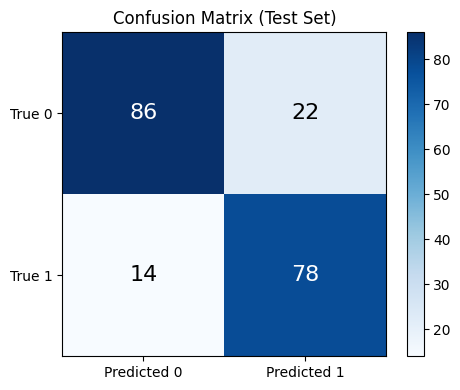

In [6]:
# Confusion matrix
cm = compute_confusion_matrix(y_test_jax, y_pred)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Predicted 0", "Predicted 1"])
ax.set_yticklabels(["True 0", "True 1"])
ax.set_title("Confusion Matrix (Test Set)")

for i in range(2):
    for j in range(2):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j, i, str(cm[i, j]), ha="center", va="center", color=color, fontsize=16)

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Decision boundary

Visualizing the decision boundary in 2D helps us see how the discovered
expression partitions the feature space.

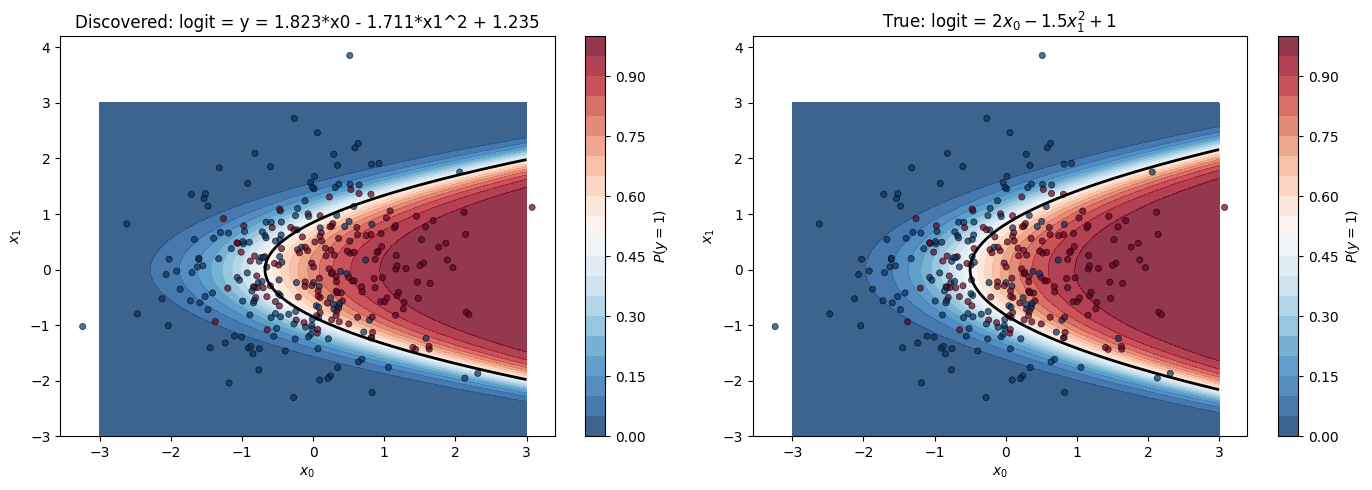

In [7]:
# Plot decision boundary
xx, yy = np.meshgrid(
    np.linspace(-3, 3, 200),
    np.linspace(-3, 3, 200),
)
grid = jnp.array(np.column_stack([xx.ravel(), yy.ravel()]))
proba_grid = np.array(clf.predict_proba(grid)[:, 1]).reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: discovered boundary
ax = axes[0]
cs = ax.contourf(xx, yy, proba_grid, levels=20, cmap="RdBu_r", alpha=0.8)
ax.contour(xx, yy, proba_grid, levels=[0.5], colors="k", linewidths=2)
scatter = ax.scatter(
    X[:, 0], X[:, 1], c=y, cmap="RdBu_r", edgecolors="k", linewidth=0.5, s=20, alpha=0.7
)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_title(f"Discovered: logit = {clf.expression_}")
fig.colorbar(cs, ax=ax, label="$P(y=1)$")

# Right: true boundary for comparison
ax = axes[1]
true_logits = 2.0 * xx - 1.5 * yy**2 + 1.0
true_proba = 1.0 / (1.0 + np.exp(-true_logits))
cs = ax.contourf(xx, yy, true_proba, levels=20, cmap="RdBu_r", alpha=0.8)
ax.contour(xx, yy, true_proba, levels=[0.5], colors="k", linewidths=2)
ax.scatter(
    X[:, 0], X[:, 1], c=y, cmap="RdBu_r", edgecolors="k", linewidth=0.5, s=20, alpha=0.7
)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_title("True: logit = $2x_0 - 1.5x_1^2 + 1$")
fig.colorbar(cs, ax=ax, label="$P(y=1)$")

plt.tight_layout()
plt.show()

## Selection strategies

`SymbolicClassifier` supports the same model-selection strategies as
`SymbolicRegressor`.  Each trades off computation against optimality.

In [8]:
strategies = ["greedy_forward", "greedy_backward", "exhaustive", "lasso_path"]

print(f"{'Strategy':20s} {'Expression':45s} {'Accuracy':>8s}  {'BIC':>8s}")
print("-" * 90)

for strat in strategies:
    m = SymbolicClassifier(
        basis_library=library,
        max_terms=5,
        strategy=strat,
        information_criterion="bic",
    )
    m.fit(X_jax, y_jax)
    expr = m.expression_
    acc = m.score(X_jax, y_jax)
    bic = m.metrics_["bic"]
    print(f"{strat:20s} {expr:45s} {acc:8.4f}  {bic:8.2f}")

Strategy             Expression                                    Accuracy       BIC
------------------------------------------------------------------------------------------
greedy_forward       y = 1.823*x0 - 1.711*x1^2 + 1.235               0.7800    276.40


greedy_backward      y = 1.235 + 1.823*x0 - 1.711*x1^2               0.7800    276.40


exhaustive           y = 1.235 + 1.823*x0 - 1.711*x1^2               0.7800    276.40


lasso_path           y = 1.234 + 1.843*x0 - 0.01065*x0^3 - 1.707*x1^2   0.7800    282.09


## Pareto front: complexity vs fit

The Pareto front shows the trade-off between model complexity and
negative log-likelihood.  Simpler models are more interpretable;
more complex models fit better.

Pareto Front (Complexity vs NLL):
Complexity         NLL         BIC  Expression
--------------------------------------------------------------------------------
         1    173.7852      353.27  y = 1.176*x0
         3    129.6424      276.40  y = 1.823*x0 - 1.711*x1^2 + 1.235


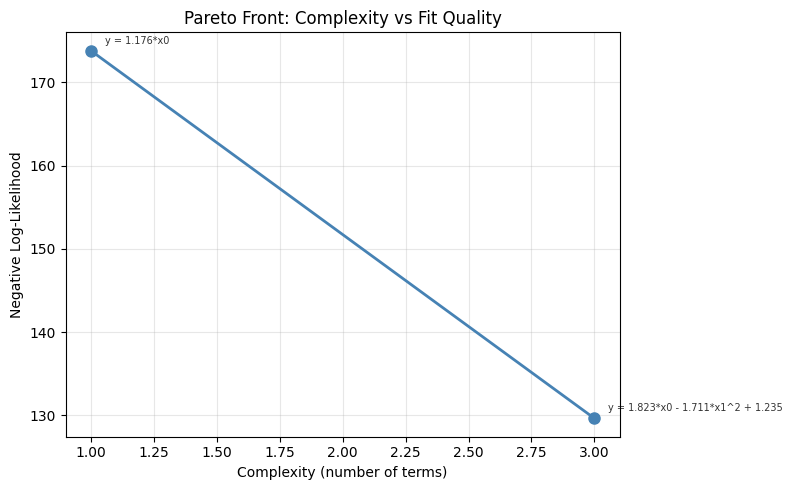

In [9]:
print("Pareto Front (Complexity vs NLL):")
print(f"{'Complexity':>10s}  {'NLL':>10s}  {'BIC':>10s}  Expression")
print("-" * 80)
for result in clf.pareto_front_:
    print(
        f"{result.complexity:10d}  {result.neg_log_likelihood:10.4f}  "
        f"{result.bic:10.2f}  {result.expression()}"
    )

# Plot the Pareto front
complexities = [r.complexity for r in clf.pareto_front_]
nlls = [r.neg_log_likelihood for r in clf.pareto_front_]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(complexities, nlls, "o-", color="steelblue", markersize=8, linewidth=2)
for i, r in enumerate(clf.pareto_front_):
    ax.annotate(
        r.expression(),
        (complexities[i], nlls[i]),
        textcoords="offset points",
        xytext=(10, 5),
        fontsize=7,
        alpha=0.8,
    )
ax.set_xlabel("Complexity (number of terms)")
ax.set_ylabel("Negative Log-Likelihood")
ax.set_title("Pareto Front: Complexity vs Fit Quality")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Coefficient confidence intervals

For binary classifiers, `coefficient_intervals()` returns Wald confidence
intervals based on the Fisher information matrix
$I(w) = \Phi^T \, \text{diag}(\mu(1-\mu)) \, \Phi$, where $\mu = \sigma(\Phi w)$.
Standard errors come from $\sqrt{\text{diag}(I^{-1})}$ with Normal quantiles
(MLE asymptotics).

In [10]:
intervals = clf.coefficient_intervals(alpha=0.05)

print("95% Wald Confidence Intervals:")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'z':>8s} {'p-value':>10s}   95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    z_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.norm.cdf(abs(z_val))))
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(
        f"  {name:>15s} {est:10.4f} {se:9.4f} {z_val:8.2f} {p_val:10.2e}"
        f"   [{lo:.4f}, {hi:.4f}] {sig}"
    )
print("  --- *** p<0.001, ** p<0.01, * p<0.05")
print()
print("Note: Uses Normal quantiles (MLE asymptotics), not t-distribution.")

95% Wald Confidence Intervals:
             Term   Estimate   Std Err        z    p-value   95% CI
  ---------------------------------------------------------------------------
               x0     1.8235    0.2362     7.72   1.15e-14   [1.3606, 2.2863] ***
             x1^2    -1.7111    0.2574    -6.65   3.00e-11   [-2.2157, -1.2065] ***
                1     1.2348    0.2285     5.40   6.53e-08   [0.7869, 1.6826] ***
  --- *** p<0.001, ** p<0.01, * p<0.05

Note: Uses Normal quantiles (MLE asymptotics), not t-distribution.


## Bootstrap coefficient uncertainty

Pairs bootstrap resamples $(X_i, y_i)$ pairs, refits IRLS on each bootstrap
sample, and collects coefficient distributions.  This gives a nonparametric
uncertainty estimate.

Bootstrap 95% Coefficient Intervals (500 resamples):
             Term       Mean      Lower      Upper        Std
  -------------------------------------------------------
               x0     1.8660     1.4667     2.3547     0.2314
             x1^2    -1.7561    -2.2923    -1.3175     0.2518
                1     1.2612     0.8245     1.6848     0.2264


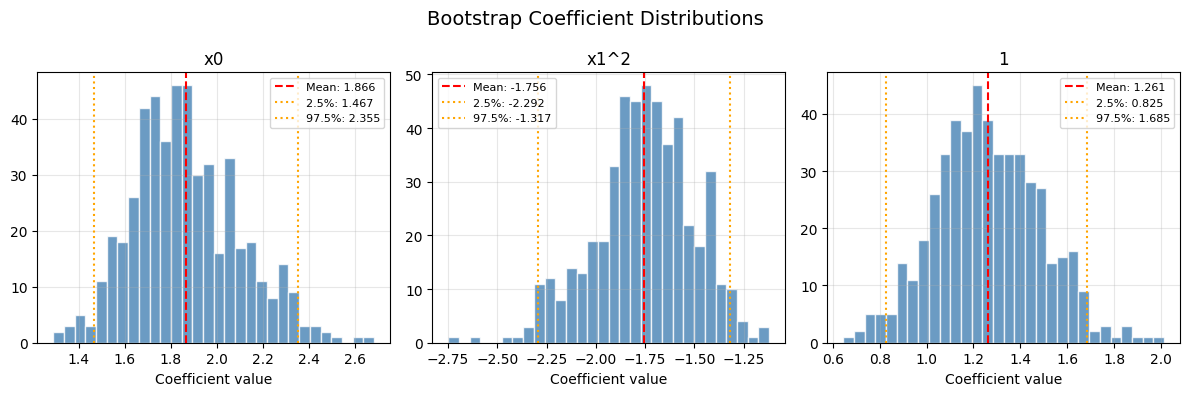

In [11]:
boot = bootstrap_classification_coefficients(clf, n_bootstrap=500, alpha=0.05, seed=42)

print("Bootstrap 95% Coefficient Intervals (500 resamples):")
print(f"  {'Term':>15s} {'Mean':>10s} {'Lower':>10s} {'Upper':>10s} {'Std':>10s}")
print("  " + "-" * 55)
for name, mean, lo, hi, std in zip(
    boot["names"],
    boot["mean"],
    boot["lower"],
    boot["upper"],
    boot["std"],
    strict=False,
):
    print(f"  {name:>15s} {float(mean):10.4f} {float(lo):10.4f} {float(hi):10.4f} {float(std):10.4f}")

# Plot bootstrap distributions
n_coefs = boot["coefficients"].shape[1]
fig, axes = plt.subplots(1, n_coefs, figsize=(4 * n_coefs, 4))
if n_coefs == 1:
    axes = [axes]

for i, (ax, name) in enumerate(zip(axes, boot["names"], strict=False)):
    ax.hist(boot["coefficients"][:, i], bins=30, color="steelblue", edgecolor="white", alpha=0.8)
    ax.axvline(float(boot["mean"][i]), color="r", linestyle="--", label=f"Mean: {float(boot['mean'][i]):.3f}")
    ax.axvline(float(boot["lower"][i]), color="orange", linestyle=":", label=f"2.5%: {float(boot['lower'][i]):.3f}")
    ax.axvline(float(boot["upper"][i]), color="orange", linestyle=":", label=f"97.5%: {float(boot['upper'][i]):.3f}")
    ax.set_xlabel("Coefficient value")
    ax.set_title(name)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Bootstrap Coefficient Distributions", fontsize=14)
plt.tight_layout()
plt.show()

## Probability calibration

A well-calibrated classifier produces predicted probabilities that match
observed frequencies.  The **reliability diagram** (or calibration curve)
bins predicted probabilities and compares the average prediction to the
actual fraction of positives in each bin.

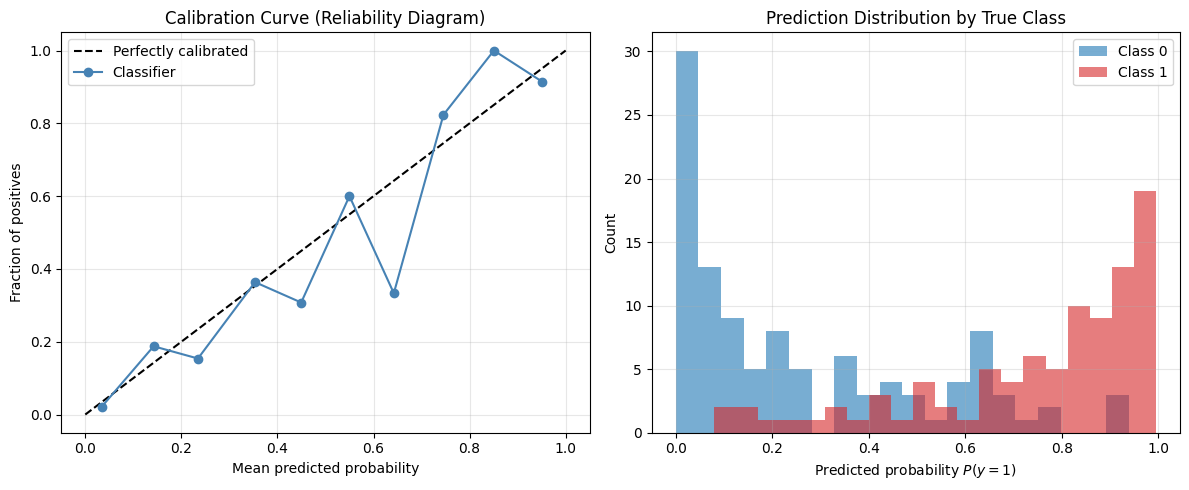

In [12]:
# Calibration on test data
y_proba_test = np.array(clf.predict_proba(X_test_jax)[:, 1])
y_bin_test = np.array(y_test_jax)

cal = calibration_curve(y_bin_test, y_proba_test, n_bins=10)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: reliability diagram
ax = axes[0]
ax.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax.plot(
    cal["mean_predicted_value"],
    cal["fraction_of_positives"],
    "o-",
    color="steelblue",
    label="Classifier",
)
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("Calibration Curve (Reliability Diagram)")
ax.legend()
ax.grid(True, alpha=0.3)

# Right: prediction histogram
ax = axes[1]
ax.hist(y_proba_test[y_bin_test == 0], bins=20, alpha=0.6, label="Class 0", color="tab:blue")
ax.hist(y_proba_test[y_bin_test == 1], bins=20, alpha=0.6, label="Class 1", color="tab:red")
ax.set_xlabel("Predicted probability $P(y=1)$")
ax.set_ylabel("Count")
ax.set_title("Prediction Distribution by True Class")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conformal prediction sets

Conformal prediction provides distribution-free coverage guarantees.
Instead of a single predicted class, conformal prediction returns a
**prediction set** — a set of labels guaranteed to contain the true
label with probability $\geq 1 - \alpha$.

The nonconformity score is $s(x, y) = 1 - P(y \mid x)$: points where
the model is uncertain will have larger prediction sets.

In [13]:
# Use test data as calibration, predict on new points
np.random.seed(99)
X_new = np.random.randn(10, 2)
logits_new = 2.0 * X_new[:, 0] - 1.5 * X_new[:, 1] ** 2 + 1.0
probs_new = 1.0 / (1.0 + np.exp(-logits_new))
y_new = (np.random.rand(10) < probs_new).astype(float)

conformal = clf.predict_conformal(
    jnp.array(X_new),
    alpha=0.10,  # 90% coverage
    X_cal=X_test_jax,
    y_cal=y_test_jax,
)

print("Conformal Prediction Sets (90% coverage):")
print(f"  {'Point':>6s}  {'True':>5s}  {'Pred':>5s}  {'P(y=1)':>7s}  Prediction Set")
print("  " + "-" * 50)
proba_new = clf.predict_proba(jnp.array(X_new))
for i in range(len(X_new)):
    pred = int(conformal["y_pred"][i])
    true = int(y_new[i])
    prob = float(proba_new[i, 1])
    pset = conformal["prediction_sets"][i]
    covered = true in pset
    marker = "" if covered else " <-- MISS"
    print(f"  {i:6d}  {true:5d}  {pred:5d}  {prob:7.3f}  {pset}{marker}")

Conformal Prediction Sets (90% coverage):
   Point   True   Pred   P(y=1)  Prediction Set
  --------------------------------------------------
       0      0      0    0.002  {0}
       1      1      0    0.218  {0} <-- MISS
       2      1      1    0.720  {1}
       3      1      1    0.809  {1}
       4      0      0    0.000  {0}
       5      1      1    0.532  {0, 1}
       6      1      1    0.715  {1}
       7      1      0    0.142  {0} <-- MISS
       8      1      1    0.906  {1}
       9      1      0    0.431  {0, 1}


## Expression export

Like `SymbolicRegressor`, the classifier exports discovered expressions
as SymPy objects, LaTeX strings, or pure NumPy callables.  The export
wraps the linear predictor with the sigmoid function.

In [14]:
# SymPy expression (wraps linear predictor with sigmoid)
sympy_expr = clf.to_sympy()
print(f"SymPy expression: {sympy_expr}")

# LaTeX
latex = clf.to_latex()
print(f"\nLaTeX: {latex}")

# Pure NumPy callable
predict_fn = clf.to_callable()
X_demo = np.array([[1.0, 0.0], [0.0, 2.0], [-1.0, -1.0]])
proba_demo = predict_fn(X_demo)

print("\nPure NumPy predictions (no JAX needed):")
for i in range(len(X_demo)):
    print(
        f"  x = {X_demo[i].tolist()} -> "
        f"P(y=0) = {proba_demo[i, 0]:.4f}, P(y=1) = {proba_demo[i, 1]:.4f}"
    )

# Verify callable matches predict_proba
proba_jax = np.array(clf.predict_proba(jnp.array(X_demo)))
print(f"\nMax difference vs predict_proba: {np.max(np.abs(proba_demo - proba_jax)):.2e}")

SymPy expression: 1/(0.290898350314531*exp(-1.82346820831299*x0 + 1.71112668514252*x1**2.0) + 1)

LaTeX: \frac{1}{0.290898350314531 e^{- 1.82346820831299 x_{0} + 1.71112668514252 x_{1}^{2.0}} + 1}

Pure NumPy predictions (no JAX needed):
  x = [1.0, 0.0] -> P(y=0) = 0.0449, P(y=1) = 0.9551
  x = [0.0, 2.0] -> P(y=0) = 0.9964, P(y=1) = 0.0036
  x = [-1.0, -1.0] -> P(y=0) = 0.9089, P(y=1) = 0.0911

Max difference vs predict_proba: 0.00e+00


## Multiclass classification

For more than two classes, `SymbolicClassifier` uses **one-vs-rest** (OVR).
Each class gets its own binary logistic model with an interpretable
expression.  Probabilities are normalized across classes.

We demonstrate this with three clusters that require nonlinear boundaries.

In [15]:
# Generate 3-class data with distinct regions
np.random.seed(42)
n_per_class = 100

# Class 0: centered at (-1.5, 0)
X0 = np.random.randn(n_per_class, 2) * 0.8 + np.array([-1.5, 0])
# Class 1: centered at (1.5, 0)
X1 = np.random.randn(n_per_class, 2) * 0.8 + np.array([1.5, 0])
# Class 2: centered at (0, 2)
X2 = np.random.randn(n_per_class, 2) * 0.8 + np.array([0, 2])

X_mc = np.vstack([X0, X1, X2])
y_mc = np.array([0] * n_per_class + [1] * n_per_class + [2] * n_per_class, dtype=float)

X_mc_jax = jnp.array(X_mc)
y_mc_jax = jnp.array(y_mc)

print(f"Multiclass data: {len(y_mc)} samples, 3 classes ({n_per_class} each)")

Multiclass data: 300 samples, 3 classes (100 each)


In [16]:
# Build library
library_mc = (
    BasisLibrary(n_features=2, feature_names=["x0", "x1"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_interactions(max_order=2)
)

# Fit multiclass classifier
clf_mc = SymbolicClassifier(
    basis_library=library_mc,
    max_terms=4,
    strategy="greedy_forward",
    information_criterion="bic",
)
clf_mc.fit(X_mc_jax, y_mc_jax)

print(f"Training accuracy: {clf_mc.score(X_mc_jax, y_mc_jax):.4f}\n")

# Print per-class expressions
expressions = clf_mc.expression_
print("Per-class linear predictors (OVR):")
for cls, expr in expressions.items():
    print(f"  Class {cls}: logit = {expr}")

Training accuracy: 0.9133

Per-class linear predictors (OVR):
  Class 0: logit = y = - 3.163*x0 - 0.9921*x1^2 - 1.094*x1
  Class 1: logit = y = 3.551*x0 - 0.4231*x1^2 - 2.063*x1
  Class 2: logit = y = - 1.26*x0^2 + 3.012*x1 - 1.961


In [17]:
# Verify probabilities sum to 1
proba_mc = clf_mc.predict_proba(X_mc_jax)
print(f"Probability matrix shape: {proba_mc.shape}")
print(f"Row sums (should be 1.0): min={float(proba_mc.sum(axis=1).min()):.6f}, "
      f"max={float(proba_mc.sum(axis=1).max()):.6f}")

# Confusion matrix for multiclass
y_pred_mc = clf_mc.predict(X_mc_jax)
cm_mc = compute_confusion_matrix(y_mc_jax, y_pred_mc, n_classes=3)

print("\nConfusion Matrix (Training):")
print(f"  {'':10s}  Pred 0  Pred 1  Pred 2")
for i in range(3):
    print(f"  True {i:4d}  {cm_mc[i, 0]:6d}  {cm_mc[i, 1]:6d}  {cm_mc[i, 2]:6d}")

Probability matrix shape: (300, 3)
Row sums (should be 1.0): min=1.000000, max=1.000000

Confusion Matrix (Training):
              Pred 0  Pred 1  Pred 2
  True    0      93       0       7
  True    1       3      93       4
  True    2       7       5      88


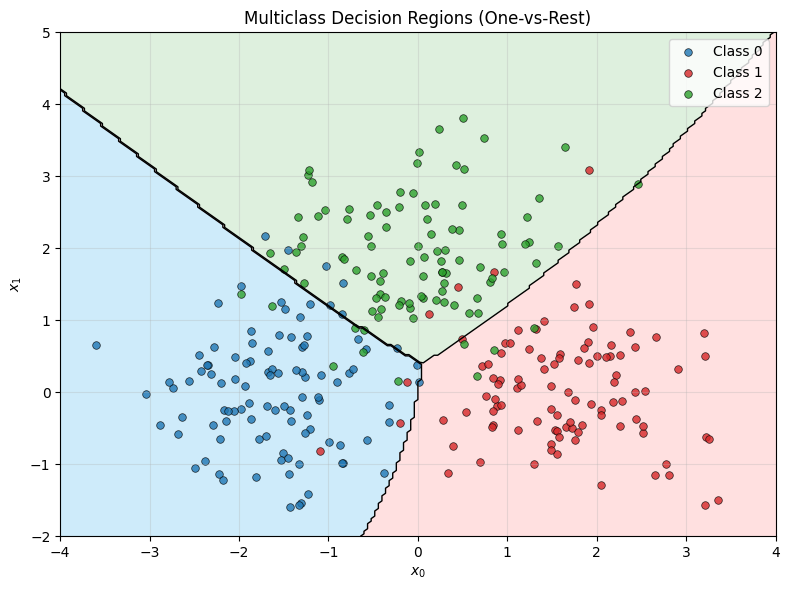

In [18]:
# Plot multiclass decision regions
xx, yy = np.meshgrid(
    np.linspace(-4, 4, 200),
    np.linspace(-2, 5, 200),
)
grid_mc = jnp.array(np.column_stack([xx.ravel(), yy.ravel()]))
pred_grid = np.array(clf_mc.predict(grid_mc)).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(xx, yy, pred_grid, levels=[-0.5, 0.5, 1.5, 2.5], colors=["#AEDFF7", "#FFCCCC", "#C8E6C9"], alpha=0.6)
ax.contour(xx, yy, pred_grid, levels=[0.5, 1.5], colors="k", linewidths=1)

colors = ["tab:blue", "tab:red", "tab:green"]
for cls in range(3):
    mask = y_mc == cls
    ax.scatter(
        X_mc[mask, 0], X_mc[mask, 1],
        c=colors[cls], edgecolors="k", linewidth=0.5, s=30,
        label=f"Class {cls}", alpha=0.8,
    )

ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_title("Multiclass Decision Regions (One-vs-Rest)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Model summary and persistence

The `summary()` method prints a comprehensive overview of the fitted model.
Models can be saved to JSON and loaded back for reproducibility.

In [19]:
# Print model summary
print(clf.summary())

JAXSR Symbolic Classification Model

Type: Binary (classes: [0.0, 1.0])
Linear predictor: y = 1.823*x0 - 1.711*x1^2 + 1.235

Selected terms (3):
  x0: 1.82347
  x1^2: -1.71113
  1: 1.23478

Metrics:
  NLL: 129.6424
  BIC: 276.40
  AIC: 265.28
  Train accuracy: 0.7800
  Log-loss: 0.4321

Training samples: 300
Strategy: greedy_forward


In [20]:
import os

# Save and reload
clf.save("classifier_demo.json")
clf_loaded = SymbolicClassifier.load("classifier_demo.json")

# Verify predictions match
proba_orig = np.array(clf.predict_proba(X_jax))
proba_loaded = np.array(clf_loaded.predict_proba(X_jax))
print(f"Max prediction difference after load: {np.max(np.abs(proba_orig - proba_loaded)):.2e}")
print(f"Loaded expression: {clf_loaded.expression_}")

# Clean up
os.remove("classifier_demo.json")

Max prediction difference after load: 0.00e+00
Loaded expression: y = 1.823*x0 - 1.711*x1^2 + 1.235


## Convenience function

For quick exploration, `fit_symbolic_classification` builds a default
basis library and fits a classifier in one call — analogous to
`fit_symbolic` for regression.

In [21]:
# Quick classification with convenience function
np.random.seed(42)
X_quick = np.random.randn(200, 2)
y_quick = (X_quick[:, 0] + X_quick[:, 1] > 0).astype(float)

clf_quick = fit_symbolic_classification(
    jnp.array(X_quick),
    jnp.array(y_quick),
    feature_names=["a", "b"],
    max_terms=4,
)

print(f"Discovered: logit = {clf_quick.expression_}")
print(f"Accuracy: {clf_quick.score(jnp.array(X_quick), jnp.array(y_quick)):.4f}")

Discovered: logit = y = 2.16*a
Accuracy: 0.7350


## Cross-validation

`cross_validate_classification` performs k-fold cross-validation,
returning mean and standard deviation of the test score.

In [22]:
from jaxsr import cross_validate_classification

cv_clf = SymbolicClassifier(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
    information_criterion="bic",
)

cv_results = cross_validate_classification(
    cv_clf, X_jax, y_jax, cv=5, scoring="accuracy", random_state=42
)

print("5-Fold Cross-Validation:")
print(f"  Mean accuracy: {cv_results['mean_test_score']:.4f}")
print(f"  Std accuracy:  {cv_results['std_test_score']:.4f}")
print(f"  Fold scores:   {[f'{s:.4f}' for s in cv_results['test_scores']]}")

5-Fold Cross-Validation:
  Mean accuracy: 0.7833
  Std accuracy:  0.0483
  Fold scores:   ['0.7667', '0.8667', '0.7833', '0.7833', '0.7167']


## Summary

| Feature | Method / Property |
|---------|------------------|
| Fit a classifier | `clf.fit(X, y)` |
| Predict labels | `clf.predict(X)` |
| Predict probabilities | `clf.predict_proba(X)` |
| Classification accuracy | `clf.score(X, y)` |
| All training metrics | `clf.metrics_` |
| Pareto front | `clf.pareto_front_` |
| Coefficient intervals (Wald) | `clf.coefficient_intervals(alpha)` |
| Conformal prediction sets | `clf.predict_conformal(X, alpha)` |
| Bootstrap coefficients | `bootstrap_classification_coefficients(clf)` |
| Calibration curve | `calibration_curve(y_true, y_prob)` |
| Export to SymPy | `clf.to_sympy()` |
| Export to LaTeX | `clf.to_latex()` |
| Export to callable | `clf.to_callable()` |
| Save / load | `clf.save(path)` / `SymbolicClassifier.load(path)` |
| Convenience fit | `fit_symbolic_classification(X, y)` |
| Cross-validation | `cross_validate_classification(clf, X, y)` |
| Individual metrics | `compute_accuracy`, `compute_f1_score`, `compute_auc_roc`, etc. |